## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
import copy
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.
mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

#make extinction the density instead of lwc
solvers[.66].medium['cloud'].attrs["density_name"] = "extinction"
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"density" : 'lwc'})
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"extinction" : 'density'})
data = copy.deepcopy(solvers[.66].medium['cloud'])
data['density'].data = carved_volume.mask.data.astype(float)*0
data['reff'].data = carved_volume.mask.data.astype(float)*0+10

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, data
)


In [6]:
%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)
solvers_reconstruct = at3d.containers.SolversDict()

In [12]:
# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
def train_density(density):
    # add an uncertainty model to the observations.
    uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)
    #at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    sensors.add_uncertainty_model('MSPI', uncertainty)
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
        )
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = density
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    x0 = state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction)

    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

    optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
    warnings.filterwarnings('ignore')
    optimizer._options['maxiter'] = 10
    result = optimizer.minimize(x0)
    grid_to_optical_properties._fixed_dataset['density'].data = solvers_reconstruct[0.66].medium['cloud'].density.data


In [8]:
# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
def train_reff(reff):
    # add an uncertainty model to the observations.
    uncertainty = at3d.uncertainties.NullUncertainty('L2',1e12)
    #at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    sensors.add_uncertainty_model('MSPI', uncertainty)
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data))
        )
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_reff = reff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

    optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
    warnings.filterwarnings('ignore')
    optimizer._options['maxiter'] = 5
    result = optimizer.minimize(x0)
    grid_to_optical_properties._fixed_dataset['reff'].data = solvers_reconstruct[0.66].medium['cloud'].reff.data

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.702  0.391E+00    31968    61.42  0.240   [Radiance 0.660 micron]
     2  -1.265  0.435E+00    31968    61.42  0.240   [Radiance 0.660 micron]
     3  -1.633  0.451E+00    31968    61.42  0.240   [Radiance 0.660 micron]
     4  -1.896  0.290E+00    32087    62.11  0.243   [Radiance 0.660 micron]
     5  -2.265  0.163E+00    32646    65.14  0.254   [Radiance 0.660 micron]
     6  -2.278  0.877E-01    34946    76.80  0.300   [Radiance 0.660 micron]
     7  -2.342  0.636E-01    37895    89.81  0.351   [Radiance 0.660 micron]
     8  -2.462  0.512E-01    40920   101.23  0.395   [Radiance 0.660 micron]
     9  -2.537  0.413E-01    45273   115.19  0.450   [Radiance 0.660 micron]
    10  -2.617  0.348E-01    49651   126.72  0.495   [Radiance 0.660 micron]
    11  -2.715  0.300E-01    54272   137.03  0.535   [Radiance 0.660 micron]
    12  -3.022  0.300E-01    54455   137.37  0.537   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

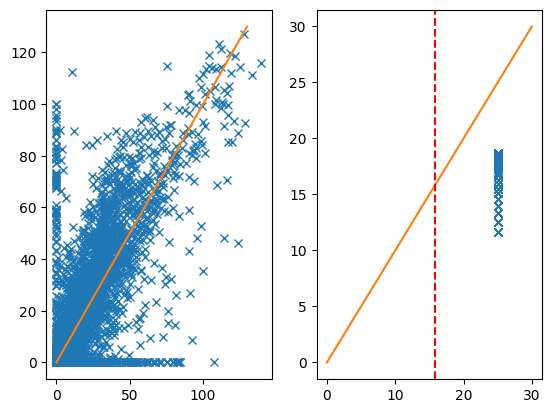

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.703  0.391E+00    31968    60.43  0.236   [Radiance 0.660 micron]
     2  -1.266  0.435E+00    31968    60.43  0.236   [Radiance 0.660 micron]
     3  -1.633  0.451E+00    31968    60.43  0.236   [Radiance 0.660 micron]
     4  -1.896  0.290E+00    32087    61.13  0.239   [Radiance 0.660 micron]
     5  -2.264  0.163E+00    32645    64.17  0.251   [Radiance 0.660 micron]
     6  -2.277  0.878E-01    34942    75.88  0.296   [Radiance 0.660 micron]
     7  -2.340  0.636E-01    37901    89.01  0.348   [Radiance 0.660 micron]
     8  -2.461  0.513E-01    40902   100.37  0.392   [Radiance 0.660 micron]
     9  -2.537  0.414E-01    45252   114.41  0.447   [Radiance 0.660 micron]
    10  -2.614  0.348E-01    49629   126.05  0.492   [Radiance 0.660 micron]
    11  -2.714  0.300E-01    54300   136.51  0.533   [Radiance 0.660 micron]
    12  -3.023  0.300E-01    54483   136.86  0.535   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

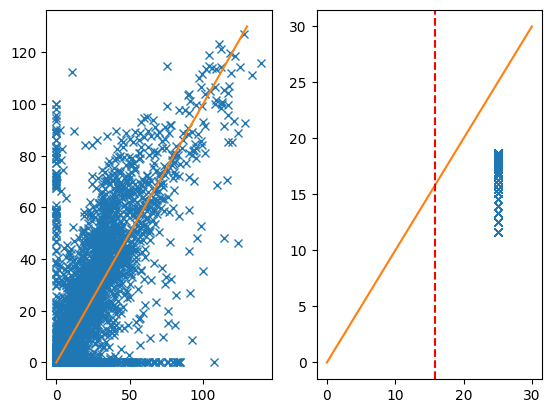

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.704  0.392E+00    31968    60.30  0.236   [Radiance 0.660 micron]
     2  -1.267  0.435E+00    31968    60.30  0.236   [Radiance 0.660 micron]
     3  -1.634  0.452E+00    31968    60.30  0.236   [Radiance 0.660 micron]
     4  -1.896  0.290E+00    32087    61.00  0.238   [Radiance 0.660 micron]
     5  -2.262  0.163E+00    32652    64.06  0.250   [Radiance 0.660 micron]
     6  -2.277  0.879E-01    34948    75.79  0.296   [Radiance 0.660 micron]
     7  -2.339  0.637E-01    37895    88.86  0.347   [Radiance 0.660 micron]
     8  -2.459  0.514E-01    40896   100.19  0.391   [Radiance 0.660 micron]
     9  -2.536  0.415E-01    45213   114.14  0.446   [Radiance 0.660 micron]
    10  -2.612  0.349E-01    49599   125.79  0.491   [Radiance 0.660 micron]
    11  -2.708  0.300E-01    54334   136.40  0.533   [Radiance 0.660 micron]
    12  -3.022  0.300E-01    54524   136.78  0.534   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

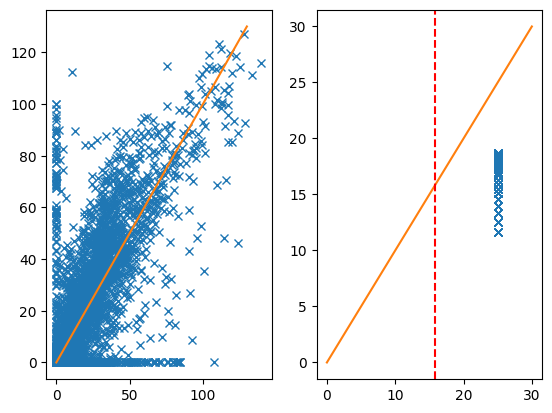

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.705  0.392E+00    31968    58.19  0.227   [Radiance 0.660 micron]
     2  -1.268  0.436E+00    31968    58.19  0.227   [Radiance 0.660 micron]
     3  -1.634  0.452E+00    31968    58.19  0.227   [Radiance 0.660 micron]
     4  -1.896  0.289E+00    32087    58.90  0.230   [Radiance 0.660 micron]
     5  -2.260  0.162E+00    32661    62.06  0.242   [Radiance 0.660 micron]
     6  -2.275  0.881E-01    34959    73.88  0.289   [Radiance 0.660 micron]
     7  -2.339  0.639E-01    37870    86.92  0.340   [Radiance 0.660 micron]
     8  -2.459  0.515E-01    40891    98.40  0.384   [Radiance 0.660 micron]
     9  -2.533  0.416E-01    45192   112.42  0.439   [Radiance 0.660 micron]
    10  -2.609  0.350E-01    49521   124.08  0.485   [Radiance 0.660 micron]
    11  -2.695  0.300E-01    54342   134.95  0.527   [Radiance 0.660 micron]
    12  -3.013  0.300E-01    54554   135.37  0.529   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

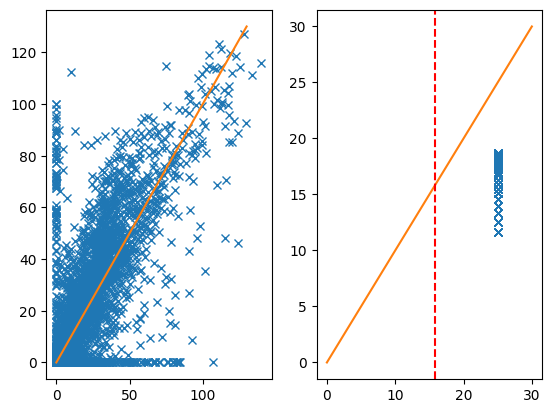

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.705  0.393E+00    31968    58.09  0.227   [Radiance 0.660 micron]
     2  -1.269  0.436E+00    31968    58.09  0.227   [Radiance 0.660 micron]
     3  -1.635  0.453E+00    31968    58.09  0.227   [Radiance 0.660 micron]
     4  -1.897  0.288E+00    32087    58.80  0.230   [Radiance 0.660 micron]
     5  -2.259  0.163E+00    32663    61.96  0.242   [Radiance 0.660 micron]
     6  -2.270  0.882E-01    34986    73.92  0.289   [Radiance 0.660 micron]
     7  -2.341  0.643E-01    37842    86.76  0.339   [Radiance 0.660 micron]
     8  -2.458  0.515E-01    40916    98.50  0.385   [Radiance 0.660 micron]
     9  -2.531  0.416E-01    45247   112.56  0.440   [Radiance 0.660 micron]
    10  -2.608  0.351E-01    49486   123.96  0.484   [Radiance 0.660 micron]
    11  -2.691  0.301E-01    54377   134.98  0.527   [Radiance 0.660 micron]
    12  -3.002  0.300E-01    54671   135.53  0.529   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

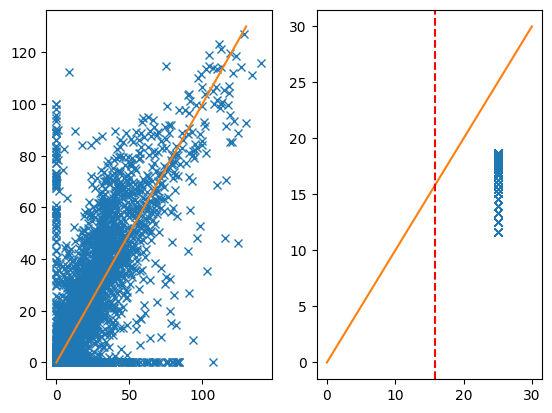

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.705  0.394E+00    31968    57.97  0.226   [Radiance 0.660 micron]
     2  -1.270  0.438E+00    31968    57.97  0.226   [Radiance 0.660 micron]
     3  -1.636  0.454E+00    31968    57.97  0.226   [Radiance 0.660 micron]
     4  -1.898  0.294E+00    32084    58.66  0.229   [Radiance 0.660 micron]
     5  -2.260  0.163E+00    32691    61.96  0.242   [Radiance 0.660 micron]
     6  -2.265  0.880E-01    35004    73.84  0.288   [Radiance 0.660 micron]
     7  -2.344  0.645E-01    37831    86.58  0.338   [Radiance 0.660 micron]
     8  -2.456  0.515E-01    40993    98.61  0.385   [Radiance 0.660 micron]
     9  -2.535  0.417E-01    45332   112.58  0.440   [Radiance 0.660 micron]
    10  -2.602  0.350E-01    49728   124.28  0.485   [Radiance 0.660 micron]
    11  -2.685  0.302E-01    54437   134.84  0.527   [Radiance 0.660 micron]
    12  -2.983  0.300E-01    54836   135.56  0.530   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

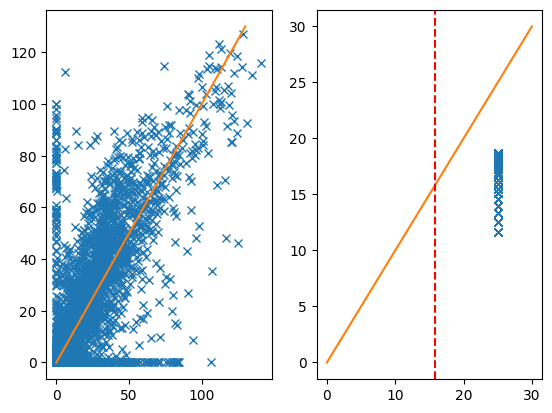

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.707  0.396E+00    31968    57.68  0.225   [Radiance 0.660 micron]
     2  -1.273  0.440E+00    31968    57.68  0.225   [Radiance 0.660 micron]
     3  -1.638  0.456E+00    31968    57.68  0.225   [Radiance 0.660 micron]
     4  -1.900  0.295E+00    32080    58.35  0.228   [Radiance 0.660 micron]
     5  -2.258  0.163E+00    32712    61.79  0.241   [Radiance 0.660 micron]
     6  -2.259  0.883E-01    35101    73.99  0.289   [Radiance 0.660 micron]
     7  -2.340  0.650E-01    37887    86.46  0.338   [Radiance 0.660 micron]
     8  -2.461  0.519E-01    41003    98.29  0.384   [Radiance 0.660 micron]
     9  -2.510  0.416E-01    45637   113.12  0.442   [Radiance 0.660 micron]
    10  -2.603  0.357E-01    49424   123.16  0.481   [Radiance 0.660 micron]
    11  -2.688  0.305E-01    54551   134.75  0.526   [Radiance 0.660 micron]
    12  -2.954  0.300E-01    55201   136.06  0.531   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

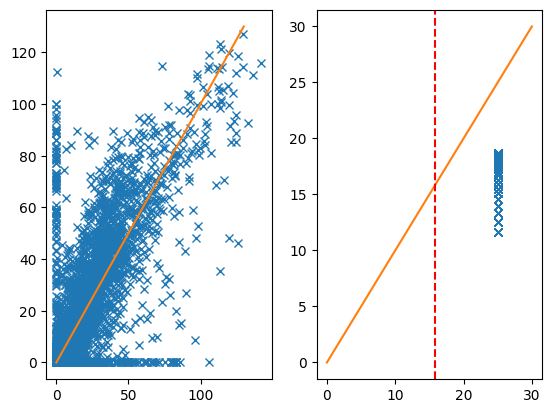

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.708  0.399E+00    31968    56.56  0.221   [Radiance 0.660 micron]
     2  -1.274  0.443E+00    31968    56.56  0.221   [Radiance 0.660 micron]
     3  -1.639  0.459E+00    31968    56.56  0.221   [Radiance 0.660 micron]
     4  -1.900  0.294E+00    32073    57.18  0.223   [Radiance 0.660 micron]
     5  -2.257  0.163E+00    32729    60.78  0.237   [Radiance 0.660 micron]
     6  -2.244  0.885E-01    35217    73.29  0.286   [Radiance 0.660 micron]
     7  -2.341  0.659E-01    37869    85.26  0.333   [Radiance 0.660 micron]
     8  -2.454  0.522E-01    41184    97.77  0.382   [Radiance 0.660 micron]
     9  -2.508  0.421E-01    45709   112.20  0.438   [Radiance 0.660 micron]
    10  -2.597  0.360E-01    49764   122.86  0.480   [Radiance 0.660 micron]
    11  -2.685  0.308E-01    54630   133.78  0.523   [Radiance 0.660 micron]
    12  -2.917  0.300E-01    55757   135.95  0.531   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

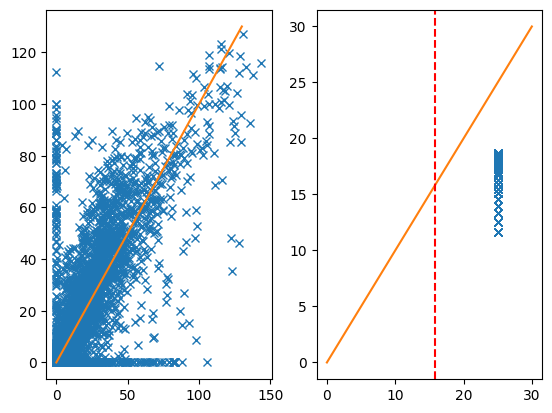

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.707  0.401E+00    31968    56.29  0.220   [Radiance 0.660 micron]
     2  -1.273  0.445E+00    31968    56.29  0.220   [Radiance 0.660 micron]
     3  -1.638  0.461E+00    31968    56.29  0.220   [Radiance 0.660 micron]
     4  -1.899  0.296E+00    32072    56.90  0.222   [Radiance 0.660 micron]
     5  -2.254  0.164E+00    32741    60.59  0.237   [Radiance 0.660 micron]
     6  -2.234  0.891E-01    35256    73.28  0.286   [Radiance 0.660 micron]
     7  -2.338  0.668E-01    37880    85.02  0.332   [Radiance 0.660 micron]
     8  -2.442  0.527E-01    41237    97.76  0.382   [Radiance 0.660 micron]
     9  -2.507  0.427E-01    45644   111.73  0.436   [Radiance 0.660 micron]
    10  -2.576  0.363E-01    49928   123.01  0.480   [Radiance 0.660 micron]
    11  -2.702  0.315E-01    54328   132.88  0.519   [Radiance 0.660 micron]
    12  -2.895  0.300E-01    56078   136.41  0.533   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

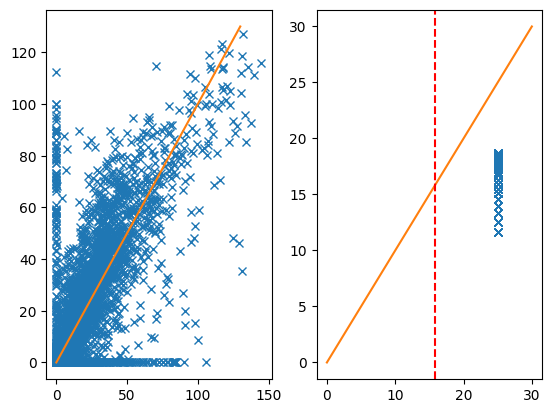

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.707  0.403E+00    31968    55.21  0.216   [Radiance 0.660 micron]
     2  -1.273  0.446E+00    31968    55.21  0.216   [Radiance 0.660 micron]
     3  -1.636  0.463E+00    31968    55.21  0.216   [Radiance 0.660 micron]
     4  -1.897  0.297E+00    32063    55.77  0.218   [Radiance 0.660 micron]
     5  -2.249  0.165E+00    32776    59.71  0.233   [Radiance 0.660 micron]
     6  -2.223  0.897E-01    35272    72.30  0.282   [Radiance 0.660 micron]
     7  -2.334  0.676E-01    37917    84.17  0.329   [Radiance 0.660 micron]
     8  -2.435  0.533E-01    41323    97.02  0.379   [Radiance 0.660 micron]
     9  -2.505  0.432E-01    45694   110.80  0.433   [Radiance 0.660 micron]
    10  -2.568  0.366E-01    50236   122.78  0.480   [Radiance 0.660 micron]
    11  -2.693  0.318E-01    54460   132.11  0.516   [Radiance 0.660 micron]
    12  -2.866  0.300E-01    56641   136.51  0.533   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

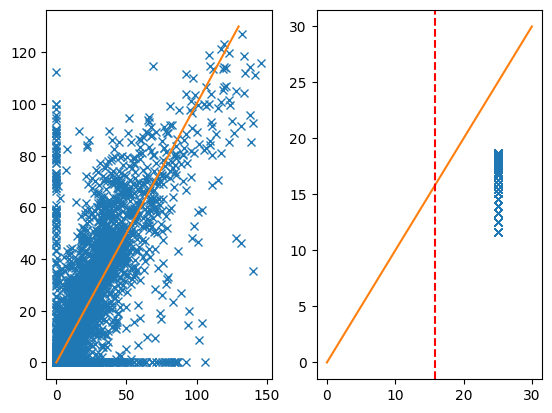


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9037     10     11   1668     0  2816   3.223D-02   2.703D+02
  F =   270.32117888049868     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [13]:
# saved = []
#train_density(data["density"].data)
solvers_reconstruct[0.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0+25
grid_to_optical_properties._fixed_dataset['reff'].data = solvers_reconstruct[0.66].medium['cloud'].reff.data
train_density(solvers_reconstruct[0.66].medium['cloud'].density.data)
# saved.append(solvers_reconstruct.copy())
# print("-------Saved " + str(i) + "--------")

In [47]:
def get_loss(reff_val):
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0+reff_val
    solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_val
    grid_to_optical_properties._fixed_dataset['reff'].data = solvers_reconstruct[0.66].medium['cloud'].reff.data
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data*0+1))
        )
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_reff = solvers_reconstruct[0.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)
    return objective_function(x0)[0]
losses = []
# for i in range(10, 25):
#     losses.append(get_loss(i))
# py.plot(range(10, 25), losses)

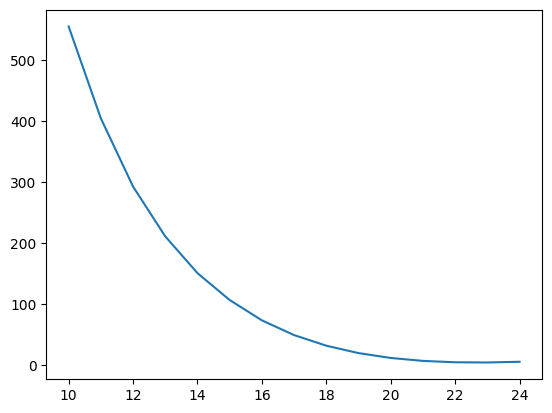

In [23]:
# solvers_reconstruct[0.66].medium['cloud'].density.data = solvers[0.66].medium['cloud'].density.data
# grid_to_optical_properties._fixed_dataset['density'].data = solvers_reconstruct[0.66].medium['cloud'].density.data
# losses = []
# for i in range(10, 25):
#     losses.append(get_loss(i))
py.plot(range(10, 25), losses)
# py.plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
#             solvers[0.66].medium['cloud'].density.data.ravel(),'x')
# py.plot([0,130],[0,130])
# py.show()

# py.plot(grid_to_optical_properties._fixed_dataset['density'].data.ravel(), 
#             solvers[0.66].medium['cloud'].density.data.ravel(),'x')
# py.plot([0,130],[0,130])
# py.show()

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.397E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.327  0.438E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.630  0.452E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.849  0.288E+00    32109    40.42  0.158   [Radiance 0.660 micron]
     5  -2.137  0.168E+00    32845    44.90  0.175   [Radiance 0.660 micron]
     6  -2.208  0.999E-01    34908    55.92  0.218   [Radiance 0.660 micron]
     7  -2.327  0.722E-01    37818    69.87  0.273   [Radiance 0.660 micron]
     8  -2.407  0.553E-01    41474    84.69  0.331   [Radiance 0.660 micron]
     9  -2.510  0.451E-01    45849    99.50  0.389   [Radiance 0.660 micron]
    10  -2.572  0.372E-01    51119   113.71  0.444   [Radiance 0.660 micron]
    11  -2.660  0.320E-01    56458   125.70  0.491   [Radiance 0.660 micron]
    12  -2.832  0.300E-01    59512   131.64  0.514   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

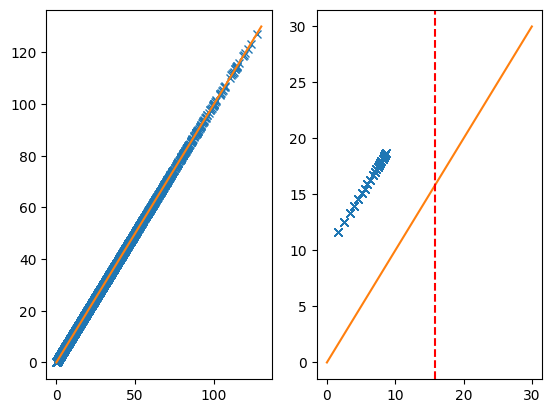

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.725  0.393E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.328  0.434E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.635  0.447E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.857  0.285E+00    32094    40.32  0.157   [Radiance 0.660 micron]
     5  -2.154  0.166E+00    32812    44.72  0.175   [Radiance 0.660 micron]
     6  -2.211  0.975E-01    34876    55.76  0.218   [Radiance 0.660 micron]
     7  -2.337  0.710E-01    37702    69.38  0.271   [Radiance 0.660 micron]
     8  -2.409  0.544E-01    41286    84.02  0.328   [Radiance 0.660 micron]
     9  -2.514  0.446E-01    45395    98.13  0.383   [Radiance 0.660 micron]
    10  -2.582  0.369E-01    50485   112.31  0.439   [Radiance 0.660 micron]
    11  -2.659  0.316E-01    55723   124.31  0.486   [Radiance 0.660 micron]
    12  -2.854  0.300E-01    58062   128.94  0.504   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

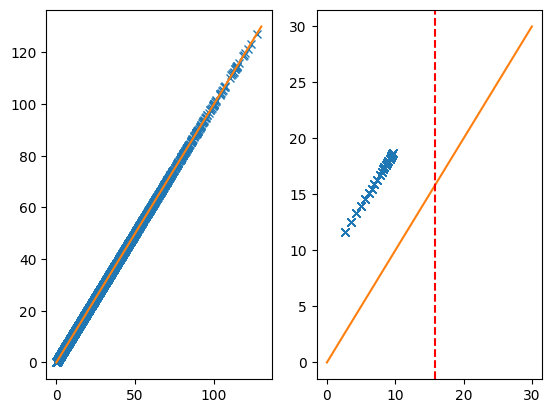

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.391E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.329  0.431E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.638  0.444E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.863  0.281E+00    32093    40.31  0.157   [Radiance 0.660 micron]
     5  -2.160  0.164E+00    32802    44.65  0.174   [Radiance 0.660 micron]
     6  -2.215  0.964E-01    34824    55.50  0.217   [Radiance 0.660 micron]
     7  -2.347  0.704E-01    37539    68.69  0.268   [Radiance 0.660 micron]
     8  -2.405  0.536E-01    41112    83.38  0.326   [Radiance 0.660 micron]
     9  -2.520  0.445E-01    44966    96.82  0.378   [Radiance 0.660 micron]
    10  -2.580  0.366E-01    49955   111.02  0.434   [Radiance 0.660 micron]
    11  -2.669  0.315E-01    54951   122.70  0.479   [Radiance 0.660 micron]
    12  -2.866  0.300E-01    57011   126.87  0.496   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

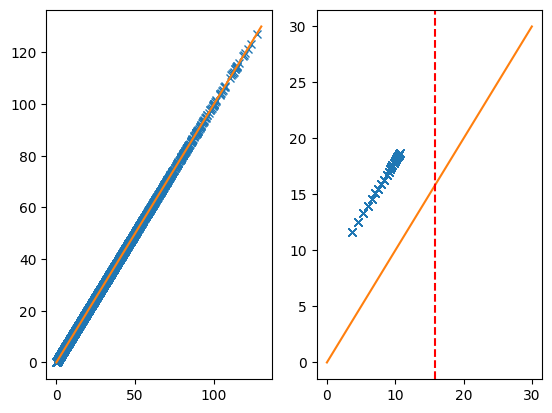

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.388E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.428E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.641  0.441E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.867  0.279E+00    32093    40.31  0.157   [Radiance 0.660 micron]
     5  -2.166  0.163E+00    32773    44.47  0.174   [Radiance 0.660 micron]
     6  -2.218  0.953E-01    34801    55.40  0.216   [Radiance 0.660 micron]
     7  -2.351  0.698E-01    37444    68.28  0.267   [Radiance 0.660 micron]
     8  -2.411  0.531E-01    40969    82.87  0.324   [Radiance 0.660 micron]
     9  -2.517  0.440E-01    44803    96.33  0.376   [Radiance 0.660 micron]
    10  -2.588  0.365E-01    49574   110.11  0.430   [Radiance 0.660 micron]
    11  -2.670  0.313E-01    54645   122.13  0.477   [Radiance 0.660 micron]
    12  -2.880  0.300E-01    56296   125.50  0.490   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

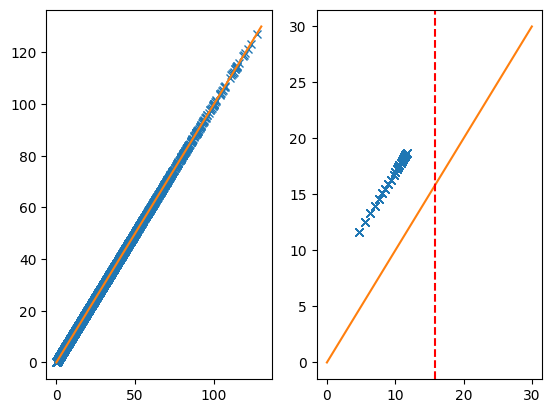

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.386E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.426E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.643  0.438E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.870  0.278E+00    32085    40.26  0.157   [Radiance 0.660 micron]
     5  -2.172  0.161E+00    32762    44.43  0.174   [Radiance 0.660 micron]
     6  -2.220  0.945E-01    34767    55.26  0.216   [Radiance 0.660 micron]
     7  -2.354  0.693E-01    37390    68.04  0.266   [Radiance 0.660 micron]
     8  -2.416  0.528E-01    40832    82.36  0.322   [Radiance 0.660 micron]
     9  -2.520  0.437E-01    44604    95.72  0.374   [Radiance 0.660 micron]
    10  -2.584  0.363E-01    49432   109.75  0.429   [Radiance 0.660 micron]
    11  -2.678  0.313E-01    54123   120.99  0.473   [Radiance 0.660 micron]
    12  -2.889  0.300E-01    55753   124.42  0.486   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

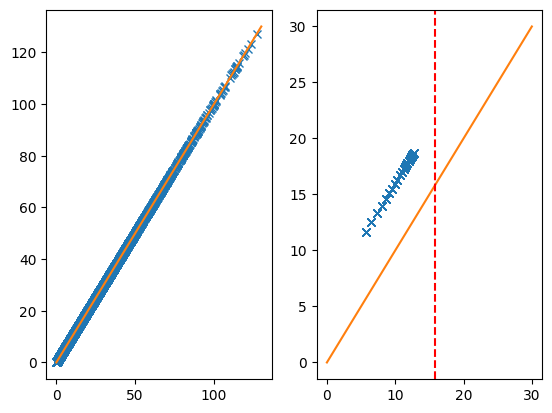

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.384E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.424E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.645  0.436E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.872  0.276E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.173  0.160E+00    32754    44.38  0.173   [Radiance 0.660 micron]
     6  -2.224  0.940E-01    34732    55.09  0.215   [Radiance 0.660 micron]
     7  -2.359  0.688E-01    37345    67.84  0.265   [Radiance 0.660 micron]
     8  -2.414  0.524E-01    40788    82.20  0.321   [Radiance 0.660 micron]
     9  -2.525  0.436E-01    44433    95.15  0.372   [Radiance 0.660 micron]
    10  -2.586  0.361E-01    49276   109.35  0.427   [Radiance 0.660 micron]
    11  -2.678  0.311E-01    53898   120.52  0.471   [Radiance 0.660 micron]
    12  -2.899  0.300E-01    55336   123.59  0.483   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

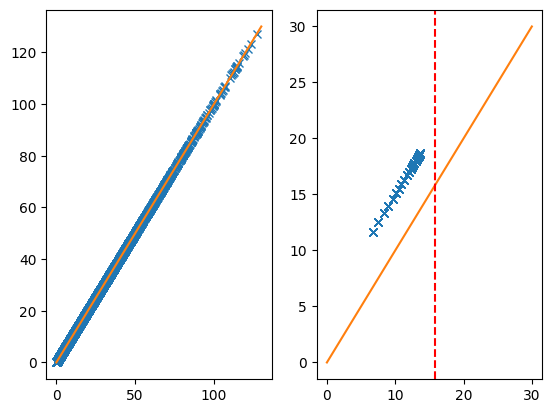

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.383E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.646  0.434E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.874  0.275E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.177  0.159E+00    32752    44.36  0.173   [Radiance 0.660 micron]
     6  -2.226  0.934E-01    34725    55.06  0.215   [Radiance 0.660 micron]
     7  -2.362  0.685E-01    37286    67.59  0.264   [Radiance 0.660 micron]
     8  -2.412  0.521E-01    40722    81.99  0.320   [Radiance 0.660 micron]
     9  -2.529  0.435E-01    44241    94.56  0.369   [Radiance 0.660 micron]
    10  -2.587  0.359E-01    49140   109.01  0.426   [Radiance 0.660 micron]
    11  -2.678  0.310E-01    53684   120.07  0.469   [Radiance 0.660 micron]
    12  -2.923  0.300E-01    54912   122.73  0.479   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

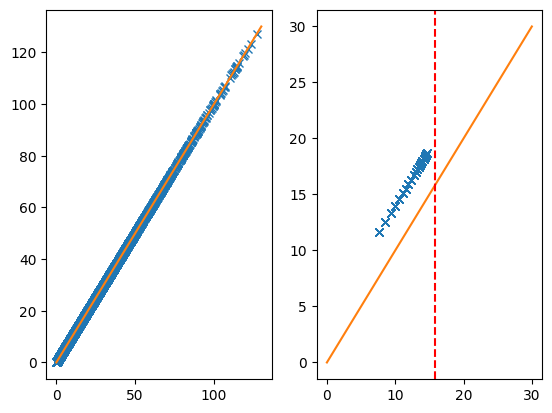

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.381E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.421E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.647  0.432E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.875  0.273E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.178  0.159E+00    32750    44.35  0.173   [Radiance 0.660 micron]
     6  -2.228  0.931E-01    34715    55.01  0.215   [Radiance 0.660 micron]
     7  -2.361  0.682E-01    37245    67.41  0.263   [Radiance 0.660 micron]
     8  -2.421  0.521E-01    40578    81.44  0.318   [Radiance 0.660 micron]
     9  -2.523  0.432E-01    44252    94.59  0.370   [Radiance 0.660 micron]
    10  -2.593  0.360E-01    48871   108.28  0.423   [Radiance 0.660 micron]
    11  -2.677  0.309E-01    53555   119.78  0.468   [Radiance 0.660 micron]
    12  -2.939  0.300E-01    54630   122.16  0.477   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

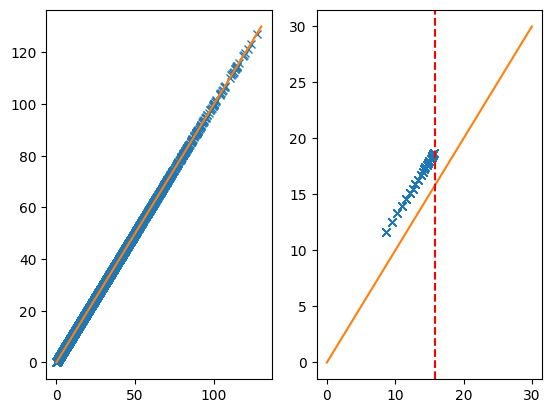

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.380E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.419E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.648  0.431E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.877  0.272E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.180  0.158E+00    32748    44.34  0.173   [Radiance 0.660 micron]
     6  -2.230  0.928E-01    34693    54.94  0.215   [Radiance 0.660 micron]
     7  -2.361  0.679E-01    37220    67.29  0.263   [Radiance 0.660 micron]
     8  -2.422  0.520E-01    40514    81.21  0.317   [Radiance 0.660 micron]
     9  -2.524  0.431E-01    44143    94.24  0.368   [Radiance 0.660 micron]
    10  -2.592  0.359E-01    48724   107.87  0.421   [Radiance 0.660 micron]
    11  -2.686  0.309E-01    53301   119.20  0.466   [Radiance 0.660 micron]
    12  -2.921  0.300E-01    54424   121.71  0.475   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

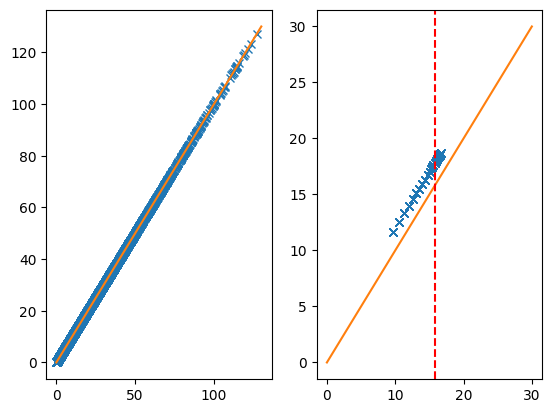

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.379E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.418E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.648  0.429E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.878  0.271E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.182  0.158E+00    32740    44.31  0.173   [Radiance 0.660 micron]
     6  -2.233  0.924E-01    34677    54.87  0.214   [Radiance 0.660 micron]
     7  -2.359  0.677E-01    37200    67.19  0.262   [Radiance 0.660 micron]
     8  -2.424  0.519E-01    40420    80.83  0.316   [Radiance 0.660 micron]
     9  -2.525  0.430E-01    44045    93.94  0.367   [Radiance 0.660 micron]
    10  -2.594  0.358E-01    48608   107.58  0.420   [Radiance 0.660 micron]
    11  -2.686  0.308E-01    53152   118.90  0.464   [Radiance 0.660 micron]
    12  -2.920  0.300E-01    54225   121.28  0.474   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

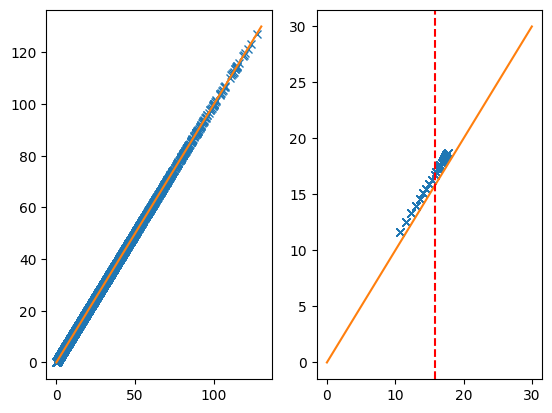

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.378E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.417E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.649  0.428E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.879  0.270E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.182  0.157E+00    32742    44.32  0.173   [Radiance 0.660 micron]
     6  -2.236  0.923E-01    34645    54.71  0.214   [Radiance 0.660 micron]
     7  -2.359  0.674E-01    37191    67.15  0.262   [Radiance 0.660 micron]
     8  -2.424  0.518E-01    40389    80.71  0.315   [Radiance 0.660 micron]
     9  -2.531  0.429E-01    43937    93.62  0.366   [Radiance 0.660 micron]
    10  -2.592  0.357E-01    48560   107.45  0.420   [Radiance 0.660 micron]
    11  -2.688  0.308E-01    52979   118.51  0.463   [Radiance 0.660 micron]
    12  -2.922  0.300E-01    54024   120.86  0.472   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

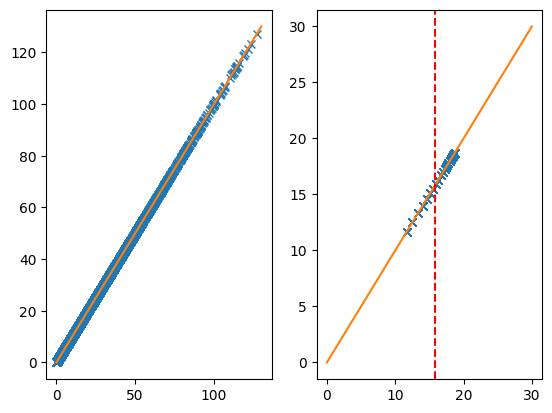

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.377E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.416E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.649  0.427E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.880  0.270E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.183  0.157E+00    32734    44.27  0.173   [Radiance 0.660 micron]
     6  -2.237  0.920E-01    34631    54.63  0.213   [Radiance 0.660 micron]
     7  -2.360  0.673E-01    37165    67.05  0.262   [Radiance 0.660 micron]
     8  -2.425  0.517E-01    40332    80.47  0.314   [Radiance 0.660 micron]
     9  -2.528  0.429E-01    43863    93.39  0.365   [Radiance 0.660 micron]
    10  -2.592  0.357E-01    48418   107.06  0.418   [Radiance 0.660 micron]
    11  -2.689  0.308E-01    52823   118.15  0.462   [Radiance 0.660 micron]
    12  -2.922  0.300E-01    53853   120.47  0.471   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

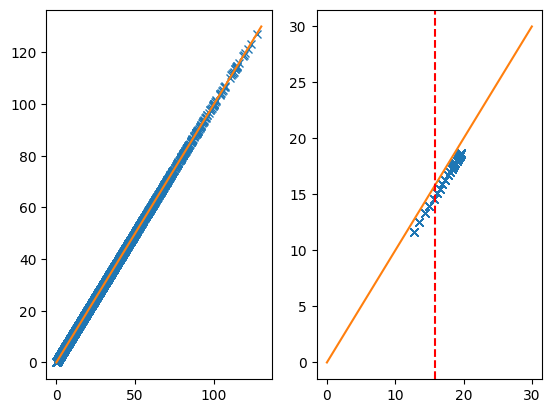

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.376E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.415E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.650  0.426E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.880  0.270E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.186  0.157E+00    32734    44.27  0.173   [Radiance 0.660 micron]
     6  -2.237  0.917E-01    34618    54.55  0.213   [Radiance 0.660 micron]
     7  -2.361  0.671E-01    37150    66.99  0.262   [Radiance 0.660 micron]
     8  -2.425  0.516E-01    40309    80.38  0.314   [Radiance 0.660 micron]
     9  -2.529  0.428E-01    43804    93.23  0.364   [Radiance 0.660 micron]
    10  -2.593  0.356E-01    48329   106.86  0.417   [Radiance 0.660 micron]
    11  -2.687  0.308E-01    52753   117.98  0.461   [Radiance 0.660 micron]
    12  -2.934  0.300E-01    53692   120.12  0.469   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

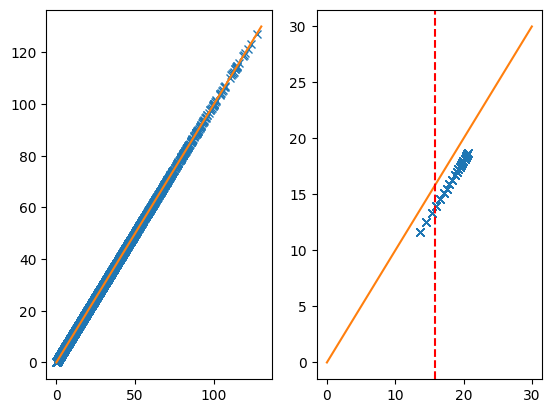

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.376E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.414E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.650  0.425E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.881  0.270E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.187  0.156E+00    32732    44.26  0.173   [Radiance 0.660 micron]
     6  -2.238  0.915E-01    34605    54.48  0.213   [Radiance 0.660 micron]
     7  -2.361  0.669E-01    37145    66.97  0.262   [Radiance 0.660 micron]
     8  -2.428  0.515E-01    40269    80.21  0.313   [Radiance 0.660 micron]
     9  -2.529  0.427E-01    43780    93.15  0.364   [Radiance 0.660 micron]
    10  -2.593  0.356E-01    48239   106.62  0.417   [Radiance 0.660 micron]
    11  -2.685  0.308E-01    52656   117.76  0.460   [Radiance 0.660 micron]
    12  -2.944  0.300E-01    53553   119.80  0.468   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

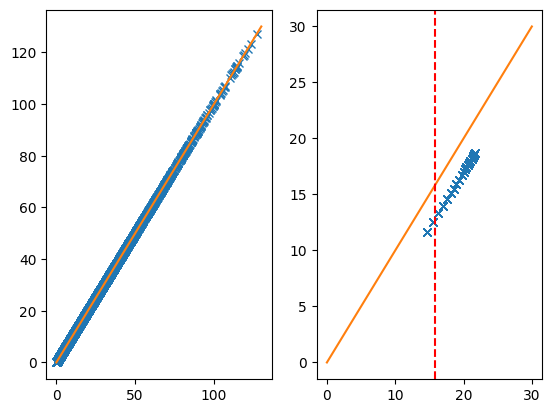

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.375E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.414E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.650  0.424E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.882  0.269E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.188  0.156E+00    32732    44.26  0.173   [Radiance 0.660 micron]
     6  -2.240  0.913E-01    34601    54.46  0.213   [Radiance 0.660 micron]
     7  -2.362  0.668E-01    37140    66.95  0.262   [Radiance 0.660 micron]
     8  -2.429  0.514E-01    40248    80.13  0.313   [Radiance 0.660 micron]
     9  -2.530  0.426E-01    43736    93.01  0.363   [Radiance 0.660 micron]
    10  -2.594  0.355E-01    48198   106.51  0.416   [Radiance 0.660 micron]
    11  -2.688  0.307E-01    52534   117.48  0.459   [Radiance 0.660 micron]
    12  -2.946  0.300E-01    53401   119.48  0.467   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

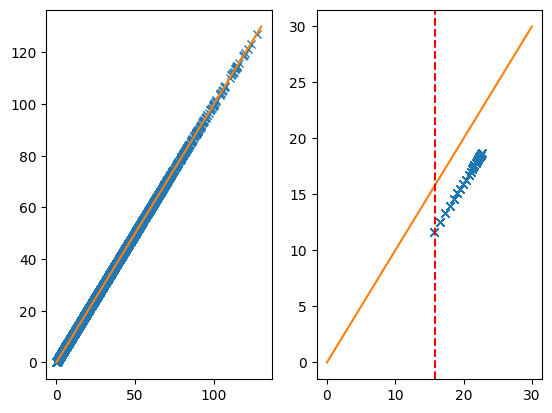

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.374E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.330  0.413E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.650  0.424E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.882  0.269E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.189  0.155E+00    32732    44.26  0.173   [Radiance 0.660 micron]
     6  -2.240  0.911E-01    34599    54.45  0.213   [Radiance 0.660 micron]
     7  -2.362  0.667E-01    37133    66.91  0.261   [Radiance 0.660 micron]
     8  -2.430  0.514E-01    40221    80.03  0.313   [Radiance 0.660 micron]
     9  -2.530  0.425E-01    43714    92.94  0.363   [Radiance 0.660 micron]
    10  -2.597  0.355E-01    48164   106.44  0.416   [Radiance 0.660 micron]
    11  -2.688  0.306E-01    52514   117.44  0.459   [Radiance 0.660 micron]
    12  -2.947  0.300E-01    53288   119.23  0.466   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

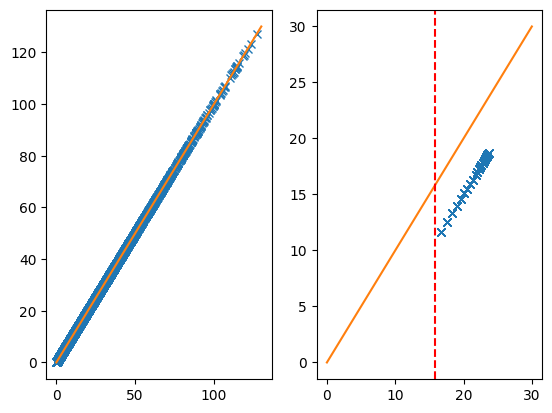

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.374E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.329  0.412E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.423E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.883  0.268E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.191  0.156E+00    32730    44.24  0.173   [Radiance 0.660 micron]
     6  -2.240  0.910E-01    34591    54.40  0.212   [Radiance 0.660 micron]
     7  -2.362  0.666E-01    37117    66.84  0.261   [Radiance 0.660 micron]
     8  -2.431  0.513E-01    40176    79.87  0.312   [Radiance 0.660 micron]
     9  -2.529  0.425E-01    43694    92.87  0.363   [Radiance 0.660 micron]
    10  -2.596  0.355E-01    48109   106.28  0.415   [Radiance 0.660 micron]
    11  -2.691  0.307E-01    52363   117.12  0.457   [Radiance 0.660 micron]
    12  -2.945  0.300E-01    53197   119.01  0.465   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

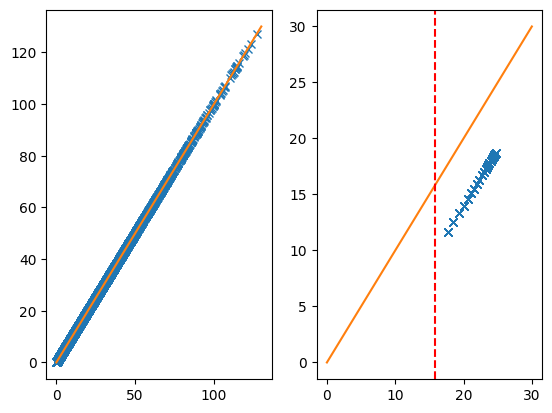

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.329  0.412E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.883  0.268E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.192  0.156E+00    32728    44.23  0.173   [Radiance 0.660 micron]
     6  -2.241  0.908E-01    34586    54.38  0.212   [Radiance 0.660 micron]
     7  -2.362  0.664E-01    37117    66.84  0.261   [Radiance 0.660 micron]
     8  -2.432  0.513E-01    40167    79.83  0.312   [Radiance 0.660 micron]
     9  -2.530  0.424E-01    43657    92.75  0.362   [Radiance 0.660 micron]
    10  -2.596  0.354E-01    48078   106.20  0.415   [Radiance 0.660 micron]
    11  -2.692  0.306E-01    52309   116.99  0.457   [Radiance 0.660 micron]
    12  -2.950  0.300E-01    53126   118.85  0.464   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

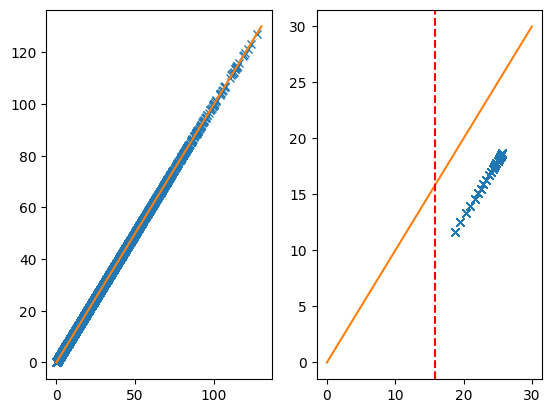

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.329  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.883  0.268E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.192  0.155E+00    32727    44.22  0.173   [Radiance 0.660 micron]
     6  -2.243  0.907E-01    34563    54.30  0.212   [Radiance 0.660 micron]
     7  -2.361  0.663E-01    37114    66.82  0.261   [Radiance 0.660 micron]
     8  -2.434  0.513E-01    40125    79.67  0.311   [Radiance 0.660 micron]
     9  -2.530  0.423E-01    43647    92.71  0.362   [Radiance 0.660 micron]
    10  -2.597  0.354E-01    48022   106.04  0.414   [Radiance 0.660 micron]
    11  -2.693  0.306E-01    52251   116.85  0.456   [Radiance 0.660 micron]
    12  -2.950  0.300E-01    53059   118.70  0.464   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

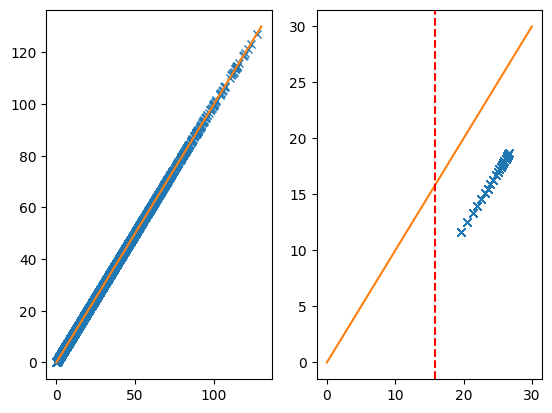

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.372E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.329  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.421E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.884  0.268E+00    32080    40.22  0.157   [Radiance 0.660 micron]
     5  -2.193  0.155E+00    32728    44.23  0.173   [Radiance 0.660 micron]
     6  -2.244  0.906E-01    34552    54.24  0.212   [Radiance 0.660 micron]
     7  -2.361  0.662E-01    37115    66.83  0.261   [Radiance 0.660 micron]
     8  -2.435  0.512E-01    40105    79.60  0.311   [Radiance 0.660 micron]
     9  -2.530  0.423E-01    43614    92.59  0.362   [Radiance 0.660 micron]
    10  -2.595  0.354E-01    47991   105.99  0.414   [Radiance 0.660 micron]
    11  -2.695  0.306E-01    52145   116.59  0.455   [Radiance 0.660 micron]
    12  -2.949  0.300E-01    52966   118.48  0.463   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

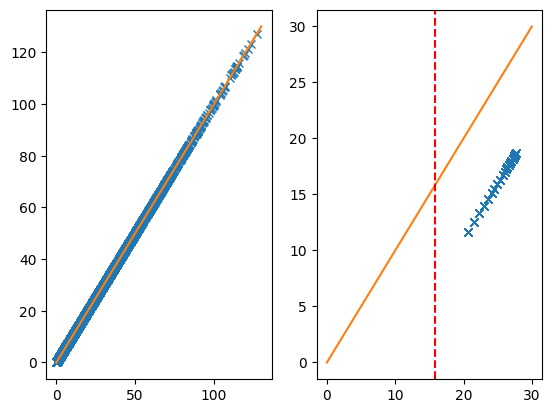

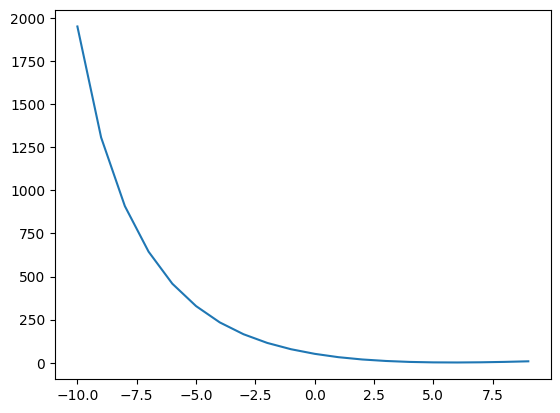

In [48]:
losses = []
for i in range(-10, 10):
    losses.append(get_loss(i))
    plot(None)
py.plot(range(-10,10),losses)